# 新闻分类: 多分类问题

上一节面对的评论只有两个分类,这一节则要面对 46 个类别.具体而言这一节是单标签的多分类问题,即每个样本只有属于一个类别.(single-label,  multiclass  classification)


# 准备数据

路透社数据集

- 1986 年发布的包含短新闻和主题的数据集
- 46 个主题/类别
- 每个主题至少有 10 个样本,每个样本只属于一个主题/类别


In [2]:
from keras.datasets import reuters

(train_data, train_labels), \
    (test_data,test_labels) = reuters.load_data(num_words=10000) #限定词频最高的 10000 个单词

如 imdb 数据集,依旧是取词频最高的前 10000 个词.


In [3]:
print(len(train_data), len(test_data))

8982 2246


训练数据有 8982 条,测试数据有 2246 条

In [4]:
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


一个样本是整数的 list.

In [5]:
word_index = reuters.get_word_index()  # 取字典
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()
                           ])  #key value 取反
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") \
                                for i in train_data[0]]) # 与 imdb 数据集相同,原 list 对应字典 0 1 2 为 padding start  of  sequence unknown 保留

In [6]:
import numpy as np


def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))  # 初始化全 0 2d 张量
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1  #sequences 第 i 个整数序列包含的整数值在 results 中的位置设为 1
    return results


x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

这是从整数 list -> 字符串的转换,索引减 3 是原 list 对应字典 0 1 2 为 padding start  of  sequence unknown 保留.

In [7]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

整数数组无法输入神经网络,必须转换成张量.

- 所有数组填充到同样长度,转换成整数张量.keras 有专门能接受这样输入的 layer.
- 使用 1D 10000 维的张量表示整数 list.list 内有那些整数,这些位置就是 1,其他位置都是 0.所谓的 one-hot 编码.

与上一节不同,这里直接使用了 keras 内置的函数完成 one-hot 编码.


## 构建模型

与 imdb 的例子相比

- 都是对文本的分类问题,输入都是整数 list 处理而来的张量.
- 分类的输出从 2 增加到了 46 种.

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

与 imdb model 的变换

- 处理的张量类型没有变化,所以 layer 种类,排列没有变换.激活函数没有变换.
- 但是隐藏层的单元增加到了 64,最后输出是 46 种类别,隐藏层单元 16 可表示的假设空间太小了.一旦某些重要信息在中间层丢失,那永远也找不回来了,必须加大假设空间.
- 2 分类最后输出的是标量概率就够了,而 46 分类标量远远不够.输出层的激活函数变成了 softmax,输出的是概率张量,1d 46 维,总和为 1.


In [9]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

对于分类问题,损失函数最好的是 categorical_crossentropy (分类交叉熵),具体原理是什么?

这里仅引用第一版的说明: 它用于衡量两个概率分布之间的距离，这里两个概率分布分别是网络输出的概率分布和标签的真实分布。通过将这两个分布的距离最小化，训练网络可使输出结果尽可能接近真实标签.


## 训练 model

In [10]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

取前 1000 个作为验证集.

In [11]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,  # 训练20轮肯定过拟合,不过是验证模型而已
    batch_size=512,
    validation_data=(x_val, y_val))


Epoch 1/20
16/16 [==============================] - 1s 20ms/step - loss: 2.4884 - accuracy: 0.5576 - val_loss: 1.6327 - val_accuracy: 0.6400
Epoch 2/20
16/16 [==============================] - 0s 12ms/step - loss: 1.3532 - accuracy: 0.7116 - val_loss: 1.2700 - val_accuracy: 0.7240
Epoch 3/20
16/16 [==============================] - 0s 12ms/step - loss: 1.0205 - accuracy: 0.7810 - val_loss: 1.1109 - val_accuracy: 0.7700
Epoch 4/20
16/16 [==============================] - 0s 13ms/step - loss: 0.8116 - accuracy: 0.8289 - val_loss: 1.0250 - val_accuracy: 0.7910
Epoch 5/20
16/16 [==============================] - 0s 14ms/step - loss: 0.6544 - accuracy: 0.8629 - val_loss: 0.9527 - val_accuracy: 0.8120
Epoch 6/20
16/16 [==============================] - 0s 12ms/step - loss: 0.5224 - accuracy: 0.8918 - val_loss: 0.9368 - val_accuracy: 0.8010
Epoch 7/20
16/16 [==============================] - 0s 13ms/step - loss: 0.4185 - accuracy: 0.9139 - val_loss: 0.9093 - val_accuracy: 0.8110
Epoch 8/20
16

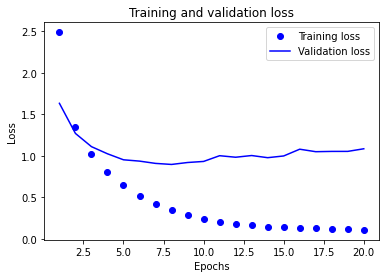

In [12]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

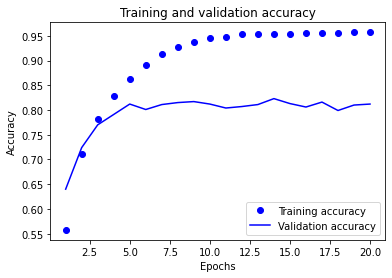

In [13]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

大约是第 9 轮开始是过拟合的拐点,因此模型训练迭代 9 次为好.


In [19]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)

Epoch 1/9
18/18 [==============================] - 1s 10ms/step - loss: 2.5390 - accuracy: 0.5636
Epoch 2/9
18/18 [==============================] - 0s 11ms/step - loss: 1.3532 - accuracy: 0.7188
Epoch 3/9
18/18 [==============================] - 0s 10ms/step - loss: 0.9916 - accuracy: 0.7917
Epoch 4/9
18/18 [==============================] - 0s 10ms/step - loss: 0.7712 - accuracy: 0.8381
Epoch 5/9
18/18 [==============================] - 0s 10ms/step - loss: 0.6092 - accuracy: 0.8743
Epoch 6/9
18/18 [==============================] - 0s 10ms/step - loss: 0.4851 - accuracy: 0.9005
Epoch 7/9
18/18 [==============================] - 0s 10ms/step - loss: 0.3959 - accuracy: 0.9173
Epoch 8/9
18/18 [==============================] - 0s 11ms/step - loss: 0.3223 - accuracy: 0.9296
Epoch 9/9
18/18 [==============================] - 0s 9ms/step - loss: 0.2683 - accuracy: 0.9404


In [21]:
results = model.evaluate(x_test, y_test)
print(results)

71/71 [==============================] - 0s 3ms/step - loss: 0.9761 - accuracy: 0.7930
[0.9760991930961609, 0.792965292930603]


In [22]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.18521816562778273

如果是完全随机分类器,二分类问题准确度是 50%,在这个问题上是 18.5%.相比之下这个 model 测试集上的精度 80% 上下.已经算好的了.


## 应用 model


In [23]:
predictions = model.predict(x_test)

In [24]:
predictions[0].shape

(46,)

In [25]:
np.argmax(predictions[0])

4

应用模型的方法还是调用 model.predict,只不过这次返回的是 1d 46 维的张量,取结果要麻烦一点点.


## 另一种处理整数 list 方式


In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

另一种处理数据方式是将其转换成整数张量.


In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

模型不需要大的改动,只是损失函数改为了 `sparse_categorical_crossentropy`,在数学上与 `categorical_crossentropy` 完全相同.


## 结论

N 分类问题,要以 N 大小的密集层为输出.

单标签多任务的问题中,最后一层要使用 softmax 激活函数.最终输出一个 1d 的概率向量.

这一类问题的损失函数清一色是 categorical_crossentropy (分类交叉熵).这在实践中证明过了.

多分类问题处理输入数据

- 转换成整数张量
- 通过 one-hot 编码再成.

如果类别较多,别吝啬内存,中间层的变量给足,避免丢失关键信息.
